In [180]:
import numpy as np
import pandas as pd
import itertools
import random
import string
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import multiprocess



In [181]:
def create_kauffman_network (n, t, p, k = 2):
    # Set of Molecules
    X = []
    F = []
    alphabet = string.ascii_uppercase[0:k]
    for i in range(1, n+1):    
        vals = [''.join(m) for m in itertools.product(alphabet, repeat=i)]
        X = X + vals
        if i <= t:
            F = F + vals
    #print(X)
    #print(F)

    # Reaction (pair of molecules)
    R = {}
    react_count = 1
    for i in range(len(X)):
        cand = X[i] + X[i]
        if len(cand) <= n:
            R[react_count] = [[X[i], X[i]], [cand]]
            react_count +=1
            #Lysis Reaction
            R[react_count] = [[cand],[X[i], X[i]]]
            react_count +=1

        for j in range(i+1, len(X)):
            cand1 = X[i] + X[j]
            cand2 = X[j] + X[i]
            if len(cand1) <= n:
                if cand2 != cand1:
                    #print(list(R.values()))
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    
                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1
                    
                    if [[X[i], X[j]], [cand2]] not in list(R.values()):
                        R[react_count] = [[X[j], X[i]], [cand2]]
                        react_count +=1
                    
                    if [[cand2],[X[i], X[j]]] not in list(R.values()):
                        R[react_count] = [[cand2],[X[j], X[i]]]
                        react_count +=1
                else:
                    if [[X[j], X[i]], [cand1]] not in list(R.values()):
                        R[react_count] = [[X[i], X[j]], [cand1]]
                        react_count +=1
                    

                    if [[cand1],[X[j], X[i]]] not in list(R.values()):
                        R[react_count] = [[cand1],[X[i], X[j]]]
                        react_count +=1

                   

    C = {}
    for i in X:
        for j in range(1, react_count):
            if np.random.random(1)[0] < p:
                if j%2 == 1:
                    k = 1
                else:
                    k = -1

                if j in C.keys():
                    if i not in C[j]:
                        C[j].append(i)
                else:
                    C[j]= [i]

                if j+k in C.keys():
                    if i not in C[j+k]:
                        C[j+k].append(i)
                else:
                    C[j+k]= [i]
    
    
                

    return (X, F, R, C)

In [118]:
def create_catalysts (X, react_count, p):
    C = {}
    for i in X:
        for j in range(1, react_count):
            if np.random.random(1)[0] < p:
                if j%2 == 1:
                    k = 1
                else:
                    k = -1

                if j in C.keys():
                    if i not in C[j]:
                        C[j].append(i)
                else:
                    C[j]= [i]

                if j+k in C.keys():
                    if i not in C[j+k]:
                        C[j+k].append(i)
                else:
                    C[j+k]= [i]
                
    return (C)

In [5]:
def graph (X, F, R, C):
    DG = nx.MultiDiGraph()

    for node in X:
   
        if node in F:
            DG.add_node(node, ncolor = "orange")
           
        else:
            DG.add_node(node, ncolor = 'lawngreen')
        

    for node in R: 
        text = "R{}".format(node)
        DG.add_node(text, ncolor = 'salmon')
    

        for i in range(len(R[node][0])):
            DG.add_edge(R[node][0][i], text, color = "steelblue")
        
        for i in range(len(R[node][1])):
            DG.add_edge(text,R[node][1][i], color ="steelblue")
  

    for j in C:
        for k in C[j]:
            if k in X and j in list(R.keys()):
                text = "R{}".format(j)
                DG.add_edge(k, text, color ="fuchsia")




    edge_colors = []

    for (u,v,attrib_dict) in list(DG.edges.data()):
        edge_colors.append(attrib_dict['color'])
    
    node_colors = list(nx.get_node_attributes(DG, "ncolor").values())
    
 


    nx.draw(DG, node_color= node_colors, edge_color = edge_colors, with_labels=True, font_weight='bold', node_size = 750, pos=nx.circular_layout(DG), connectionstyle='arc3, rad = 0.1')
    
    plt.show()

## RAF Algorithm

In [6]:
# Find all possible molecules able to be produced by the food set and available reactions

def closure(F, R):
    no_change = 0
    X = list(F)

    while no_change !=1:
        no_change = 1

        for i in list(R.values()):
            sufficient = 1
            for j in i[0]:
                if j not in X:
                    sufficient = 0
            if sufficient == 1:
                for k in i[1]:
                    if k not in X:
                        X.append(k)
                        no_change = 0
    return(X)
            


In [7]:
def Rsupp (R):
    supp = []
    for i in list(R.values()):
        cands = i[0] + i[1]
        for j in cands:
            if j not in supp:
                supp.append(j)
    return(supp)


In [8]:
def reduceR(R, C):

    catalyzed = list(C.keys())
    uncat_R = list(set(R.keys()) - set(catalyzed))


    for i in uncat_R:
        del R[i]
    
    
    no_change = 0
    while no_change != 1:
        no_change = 1

        suppR= Rsupp(R)
        Rs = list(C.keys())

        for i in Rs:
            for j in C[i]:
                if j not in suppR:
                    C[i] = C[i].remove(j)
                
                if not C[i]:
                    # print("DELETE")
                    del C[i]
                    if i in R:
                        del R[i]
                    no_change = 0
                    break
         
    return(R,C)
            

In [17]:
def reduceToF(F, R):
    W = closure(F,R)
    r_num= list(R.keys())
    
    for i in r_num:
        remove = 0
        for j in R[i][0]:
            if j not in W:
                remove = 1
                break
        if remove == 1:
            del R[i]

    
    return R

In [9]:
def RAF(X,F,R,C):
    X_old = X.copy()
    R_old = copy.deepcopy(R)

    i = 0 
    change = 0
    while change != 1:
        R, C = reduceR(R, C)
        X = closure(F,R)
        R = reduceToF(F,R)
        i= i+1

        if R != False and X != False:
            if X_old == X and R_old == R:
                change = 1
            else:
                R_old = copy.deepcopy(R)
                X_old = X.copy()
        else:
            break
    
    if not R:
        return 0
    else:
        return 1

In [339]:
["a", "b"] + ["a", "b"] 

['a', 'b', 'a', 'b']

## Simulation

In [175]:
f_min = 0.25
f_max = 0.35
pcount= 1
reps = 1000
n = 3
t = 2



In [176]:
X,F,R = create_XFR(n, t)
p_min = f_min /len(R)
p_max = f_max /len(R)
ps = np.linspace(p_min, p_max, pcount)
print(ps)
print("--")

Cs = []
RAFs = []
for p in ps: 
    for j in range(reps):
        C = create_catalysts(X, len(R),p)
        Cs.append(C)
        RAFs.append(RAF(X.copy(), F.copy(), R.copy(), C))


sum(RAFs)/(pcount * reps)


[0.00694444]
--


0.498

2


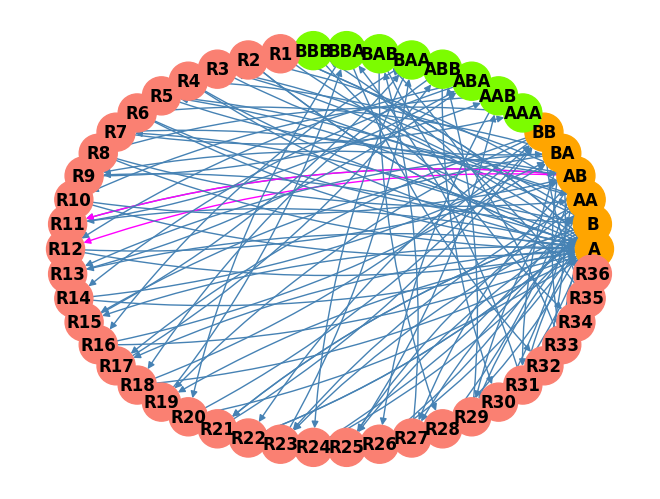

4


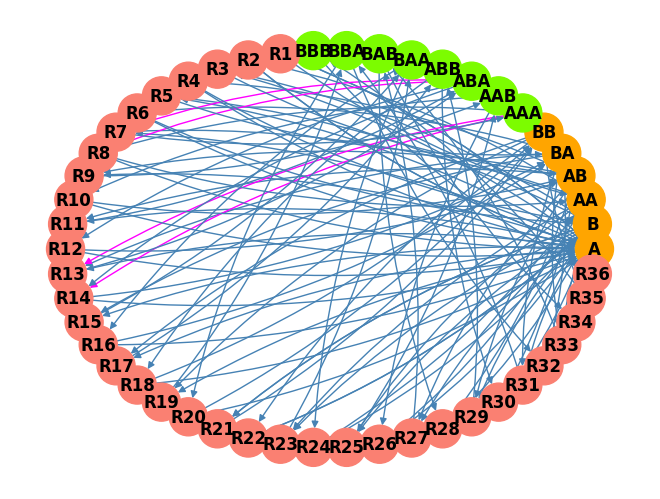

10


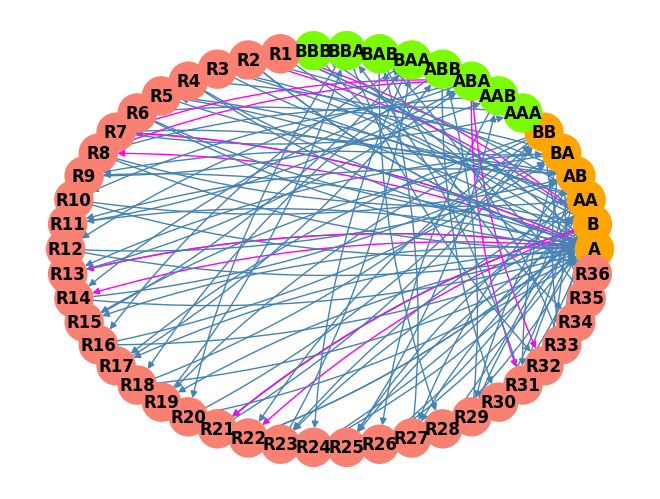

2


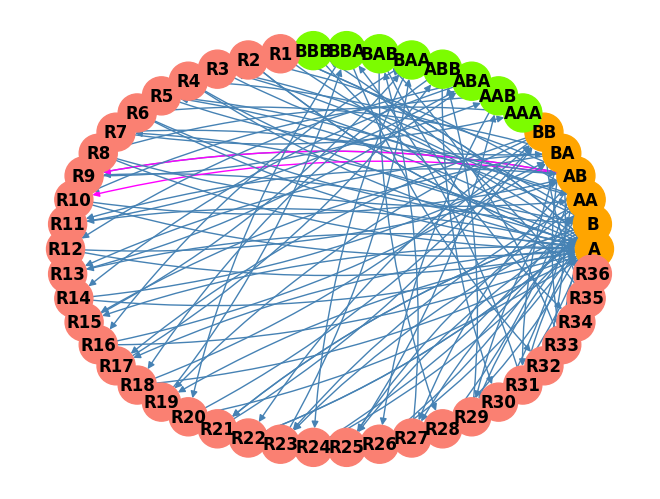

10


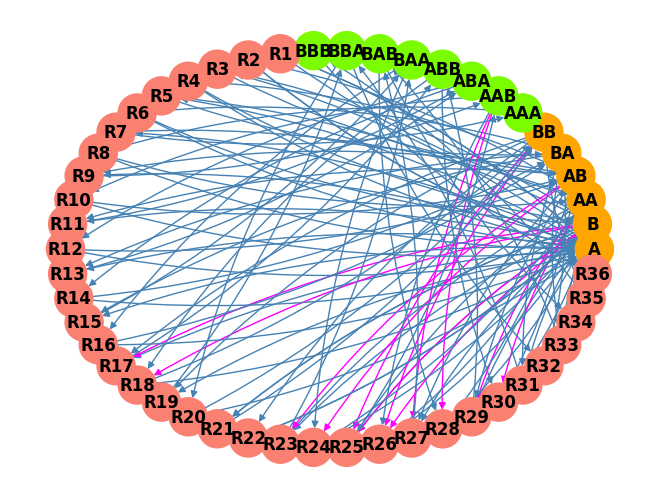

In [183]:
success= [i  for i in range(pcount * reps) if RAFs[i] == 1]
rand_success = random.sample(success,5)
for i in rand_success:
    print(len(Cs[i]))
    graph(X,F,R,Cs[i])

In [225]:
def add_catalyst(X, R, C):
    add_new = 0
    while add_new == 0:
        reaction = random.sample(list(R.keys()),1)[0]
        if reaction %2 == 1:
            k = 1
        else:
            k = -1
        catalyst = random.sample(X,1)[0]
        
        if reaction in C:
            if catalyst not in C[reaction]:
                C[reaction].append(catalyst)
                C[reaction + k].append(catalyst)
                add_new = 1

        else:
            C[reaction] = [catalyst]
            C[reaction+k] = [catalyst]
            add_new = 1
    return(C)



In [327]:
def remove_catalyst(C):
    reaction = random.sample(list(C), 1)[0]
    if reaction %2 == 1:
        k = 1
    else:
        k = -1
    
    if len(C[reaction]) == 1:
        del C[reaction]
        del C[reaction+ k]
  
    else:
      
        catalyst = random.sample(C[reaction], 1)[0]
        
        C[reaction].remove(catalyst)
        
        C[reaction+k].remove(catalyst)
       
    return(C)

In [337]:
def stability_test (N, f, n, t):
    success_stability = 0
    failure_stability = 0
    RAFs = 0


    for j in range(N):
        X,F,R = create_XFR(n, t)
        p = f/len(R)
        C = create_catalysts(X, len(R),p)
        

        raf = RAF(X.copy(), F.copy(), R.copy(), C)
        RAFs += raf
        if raf == 1:
            #print("C:{}".format(C))
            new_C = remove_catalyst(C)
            #print("New C:{}".format(new_C))
            if new_C:
                success_stability += RAF(X.copy(),F.copy(),R.copy(),new_C)
        else:
           
            #print("R:{}".format(R))
            new_C = add_catalyst(X.copy(),R.copy(), C)
            failure_stability += RAF(X,F,R,new_C)

    print("{} Trials of n = {} at f = {}".format(N, n, f))
    print("----------------------")
    print("Percentage RAF: {}".format(RAFs/N))
    print("Percentage RAF after perturbation of Stable: {}".format(success_stability/RAFs))
    print("Percentage RAF after perturbation Unstable: {}".format(failure_stability/(N-RAFs)))

    return
    
    

        


In [338]:
stability_test(10,0.5, 2, 1)

Percentage RAF: 0.8
Percentage RAF after perturbation of Stable: 0.375
Percentage RAF after perturbation Unstable: 0.0


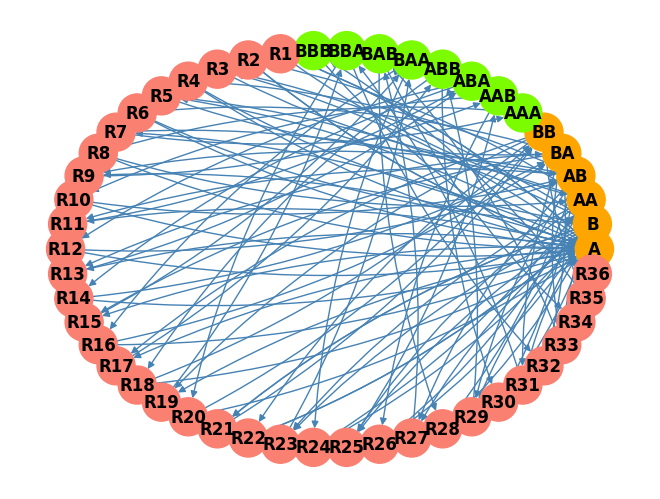

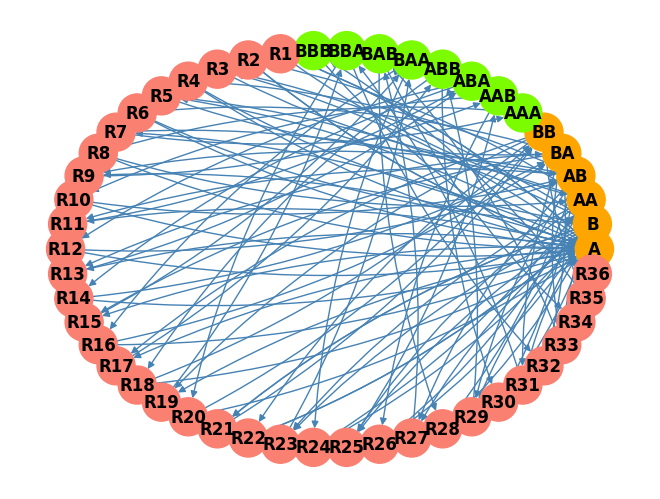

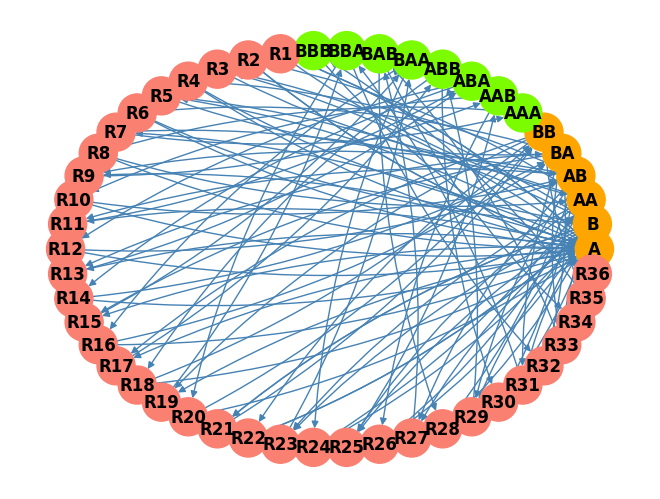

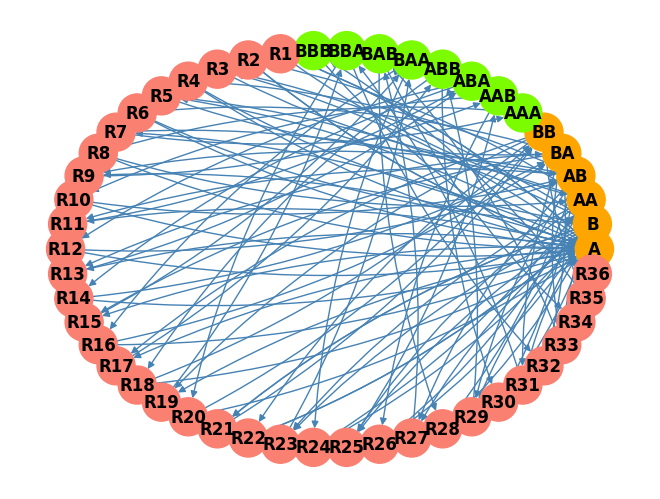

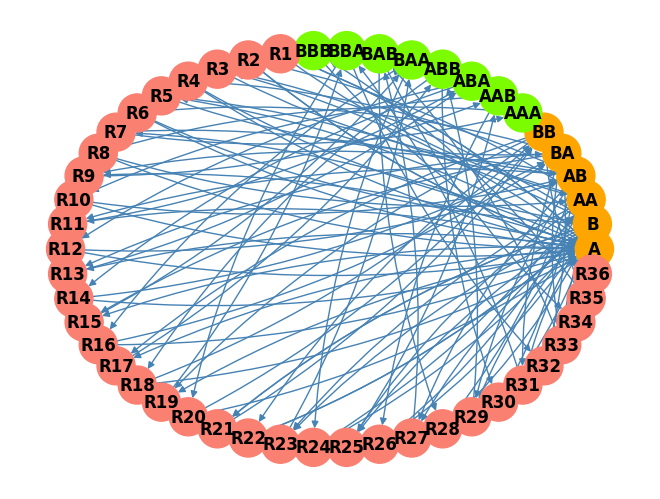

In [178]:
failure = [i  for i in range(pcount*reps) if RAFs[i] == 0]
rand_failure = random.sample(failure, 5)
for i in failure:
    #print(len(Cs[i]))
    graph(X,F,R,Cs[i])

In [179]:
failure_len = [len(Cs[i])  for i in range(pcount*reps) if RAFs[i] == 0]
sum(failure_len)

0

## Food Stability

In [384]:
def remove_catalyst(C, F):
    print(np.unique([num for sublist in list(C.values()) for num in sublist]))
    food_catalysts = list(set(np.unique([num for sublist in list(C.values()) for num in sublist])) & set(F))
    print("FC: {}".format(food_catalysts))
    if len(food_catalysts) > 0:
        catalyst = random.sample(food_catalysts, 1)[0]

        for i in list(C.keys()):
            
            if catalyst in C[i]:
                if i %2 == 1:
                    k = 1
                else:
                    k = -1

                if len(C[i]) > 1:
                    C[i].remove(catalyst)
                    C[i+k].remove(catalyst)
                else:
                    del C[i]
                    del C[i+k]
                
                break
    print(C)
    print("")
    return C

In [376]:
N = 10
n = 2
t = 1
f= 0.35

In [385]:

success_stability = 0
failure_stability = 0
RAFs = 0


for j in range(N):
    X,F,R = create_XFR(n, t)
    p = f/len(R)
    C = create_catalysts(X, len(R),p)
        

    raf = RAF(X.copy(), F.copy(), R.copy(), C)
    RAFs += raf
    if raf == 1:
            #print("C:{}".format(C))
        new_C = remove_catalyst(C,F)
            #print("New C:{}".format(new_C))
        if new_C:
            success_stability += RAF(X.copy(),F.copy(),R.copy(),new_C)
    else:
           
            #print("R:{}".format(R))
        new_C = add_catalyst(F.copy(),R.copy(), C)
        failure_stability += RAF(X,F,R,new_C)

print("{} Trials of n = {} at f = {}".format(N, n, f))
print("----------------------")
print("Percentage RAF: {}".format(RAFs/N))
print("Percentage RAF after Food Perturbation of Stable: {}".format(success_stability/RAFs))
print("Percentage RAF after Food Perturbation of Unstable: {}".format(failure_stability/(N-RAFs)))
print("")

['AA']
FC: []
{1: ['AA'], 2: ['AA'], 4: ['AA'], 3: ['AA']}

['A' 'B']
FC: ['B', 'A']
{6: [], 5: [], 7: ['B'], 8: ['B']}

['AA']
FC: []
{1: ['AA'], 2: ['AA']}

['AB' 'B']
FC: ['B']
{1: [], 2: [], 6: ['B'], 5: ['B'], 3: ['AB'], 4: ['AB']}

['BA']
FC: []
{4: ['BA'], 3: ['BA'], 5: ['BA'], 6: ['BA']}

10 Trials of n = 2 at f = 0.35
----------------------
Percentage RAF: 0.5
Percentage RAF after Food Perturbation of Stable: 1.0
Percentage RAF after Food Perturbation of Unstable: 0.2



In [380]:
success_stability

4